In [89]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # For Mac
plt.rcParams['axes.unicode_minus'] = False  # This is to display minus signs correctly



In [90]:
df_demand = pd.read_csv('./data/demand_train.csv',  encoding="gbk")
df_demand['过账日期'] = pd.to_datetime(df_demand['过账日期'])

df_demand.head(10)

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类
0,2018-01-06,0.33,2004,1000,5000,3002,4014
1,2018-01-08,0.09,2010,1000,5000,3002,4014
2,2018-01-09,0.09,2008,1000,5000,3002,4014
3,2018-01-10,0.10,2010,1000,5000,3002,4014
4,2018-01-11,0.17,2004,1000,5000,3002,4014
5,2018-01-13,0.06,2008,1000,5000,3002,4014
6,2018-01-15,0.45,2004,1000,5000,3002,4014
7,2018-01-18,0.03,2010,1000,5000,3002,4014
8,2018-01-19,0.06,2008,1000,5000,3002,4014
9,2018-01-20,0.84,2004,1000,5000,3002,4014


In [91]:
df_demand['年月'] = df_demand['过账日期'].dt.to_period('M').astype(str)
df_demand['月'] = df_demand['年月'].str[-2:]
df_demand['季度'] = df_demand['过账日期'].dt.quarter
df_demand.head()

,过账日期,需求量,工厂编码,物料编码,物料品牌,物料类型,物料品类,年月,月,季度
0,2018-01-06,0.33,2004,1000,5000,3002,4014,2018-01,01,1
1,2018-01-08,0.09,2010,1000,5000,3002,4014,2018-01,01,1
2,2018-01-09,0.09,2008,1000,5000,3002,4014,2018-01,01,1
3,2018-01-10,0.10,2010,1000,5000,3002,4014,2018-01,01,1
4,2018-01-11,0.17,2004,1000,5000,3002,4014,2018-01,01,1


In [92]:
df_demand.drop(['过账日期', '物料品牌', '物料类型', '物料品类'], axis=1, inplace=True)
df_demand.head()

,需求量,工厂编码,物料编码,年月,月,季度
0,0.33,2004,1000,2018-01,01,1
1,0.09,2010,1000,2018-01,01,1
2,0.09,2008,1000,2018-01,01,1
3,0.10,2010,1000,2018-01,01,1
4,0.17,2004,1000,2018-01,01,1


In [93]:
# 经分析 需求量与库存量、物料编码、工厂编码有很大可能存在关联性，考虑到最终预测是通过工厂编码 + 物料编码 进行预测的，故这里将数据进行预处理

df_demand['工厂编码_物料编码'] = df_demand['工厂编码'].astype(str) + '_' + df_demand['物料编码'].astype(str)
df_demand['年'] = df_demand['年月'].str[:4]
df_final = df_demand.groupby(['工厂编码_物料编码', '年月', '年', '月', '季度']).agg({'需求量': 'sum' }).reset_index()
df_final['年'] = df_final['年'].astype(int)
df_final['月'] = df_final['月'].astype(int)
df_final['季度'] = df_final['季度'].astype(int)
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量
0,2000_1001,2018-01,2018,1,1,12.53
1,2000_1001,2018-02,2018,2,1,16.08
2,2000_1001,2018-03,2018,3,1,4.71
3,2000_1001,2018-04,2018,4,2,17.69
4,2000_1001,2018-05,2018,5,2,7.97


In [94]:
def create_features(df, group_col='工厂编码_物料编码', target_col='需求量'):
    """
    创建滑动和滞后特征
    """
    # 按组排序
    df = df.sort_values([group_col, '年', '月'])
    
    # 创建滞后特征
    for lag in [1, 2, 3, 4]:
        df[f'lag_{lag}'] = df.groupby(group_col)[target_col].shift(lag)
    
    # 创建滑动窗口特征
    for window in [2, 3]:
        df[f's_roll_{window}_mean'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).mean())
        df[f's_roll_{window}_max'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).max())
        df[f's_roll_{window}_min'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).min())
        df[f's_roll_{window}_std'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).std())
        df[f's_roll_{window}_median'] = df.groupby(group_col)[target_col].transform(
            lambda x: x.rolling(window=window).median())
    
    # 创建基于滞后特征的滑动窗口特征
    for window in [2, 3]:
        df[f's_l_roll_{window}_mean'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).mean())
        df[f's_l_roll_{window}_max'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).max())
        df[f's_l_roll_{window}_min'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).min())
        df[f's_l_roll_{window}_std'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).std())
        df[f's_l_roll_{window}_median'] = df.groupby(group_col)['lag_1'].transform(
            lambda x: x.rolling(window=window).median())
    
    return df

In [95]:

df_final = create_features(df_final)

df_final.head()
    

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_2_mean,s_l_roll_2_max,s_l_roll_2_min,s_l_roll_2_std,s_l_roll_2_median,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median
0,2000_1001,2018-01,2018,1,1,12.53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000_1001,2018-02,2018,2,1,16.08,12.53,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000_1001,2018-03,2018,3,1,4.71,16.08,12.53,NaN,NaN,...,14.31,16.08,12.53,2.51,14.31,NaN,NaN,NaN,NaN,NaN
3,2000_1001,2018-04,2018,4,2,17.69,4.71,16.08,12.53,NaN,...,10.40,16.08,4.71,8.04,10.40,11.11,16.08,4.71,5.82,12.53
4,2000_1001,2018-05,2018,5,2,7.97,17.69,4.71,16.08,12.53,...,11.20,17.69,4.71,9.18,11.20,12.83,17.69,4.71,7.08,16.08


In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_final['工厂编码_物料编码'] = le.fit_transform(df_final['工厂编码_物料编码'])
df_final.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_2_mean,s_l_roll_2_max,s_l_roll_2_min,s_l_roll_2_std,s_l_roll_2_median,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median
0,0,2018-01,2018,1,1,12.53,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2018-02,2018,2,1,16.08,12.53,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2018-03,2018,3,1,4.71,16.08,12.53,NaN,NaN,...,14.31,16.08,12.53,2.51,14.31,NaN,NaN,NaN,NaN,NaN
3,0,2018-04,2018,4,2,17.69,4.71,16.08,12.53,NaN,...,10.40,16.08,4.71,8.04,10.40,11.11,16.08,4.71,5.82,12.53
4,0,2018-05,2018,5,2,7.97,17.69,4.71,16.08,12.53,...,11.20,17.69,4.71,9.18,11.20,12.83,17.69,4.71,7.08,16.08


In [97]:


# 划分训练集和测试集
df_train = df_final[df_final['年月'] < '2020-09']
df_test = df_final[df_final['年月'] >= '2020-09']
df_test.head()

,工厂编码_物料编码,年月,年,月,季度,需求量,lag_1,lag_2,lag_3,lag_4,...,s_l_roll_2_mean,s_l_roll_2_max,s_l_roll_2_min,s_l_roll_2_std,s_l_roll_2_median,s_l_roll_3_mean,s_l_roll_3_max,s_l_roll_3_min,s_l_roll_3_std,s_l_roll_3_median
30,0,2020-09,2020,9,3,1.80,6.00,13.20,10.28,21.76,...,9.60,13.20,6.00,5.09,9.60,9.83,13.20,6.00,3.62,10.28
31,0,2020-10,2020,10,4,4.80,1.80,6.00,13.20,10.28,...,3.90,6.00,1.80,2.97,3.90,7.00,13.20,1.80,5.77,6.00
32,0,2020-11,2020,11,4,8.40,4.80,1.80,6.00,13.20,...,3.30,4.80,1.80,2.12,3.30,4.20,6.00,1.80,2.16,4.80
65,1,2020-09,2020,9,3,119.76,60.96,103.72,120.84,146.80,...,82.34,103.72,60.96,30.24,82.34,95.17,120.84,60.96,30.84,103.72
66,1,2020-10,2020,10,4,131.72,119.76,60.96,103.72,120.84,...,90.36,119.76,60.96,41.58,90.36,94.81,119.76,60.96,30.40,103.72


In [98]:
#  训练模型
features = [col for col in df_final.columns if col not in ['工厂编码_物料编码', '年月', '需求量']]
target = '需求量'


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6142
[LightGBM] [Info] Number of data points in the train set: 13667, number of used features: 27
[LightGBM] [Info] Start training from score 150.472851


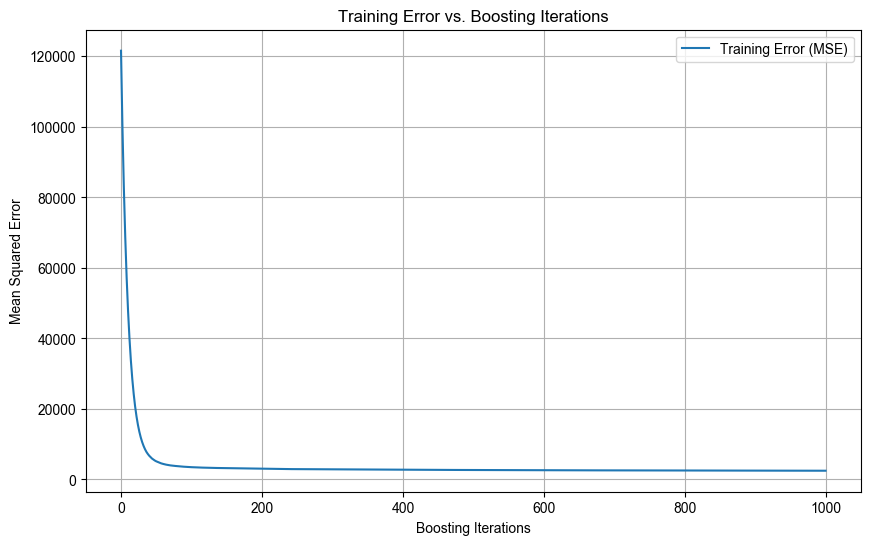

In [99]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
eval_result = {}  # 用于保存评估结果

model.fit(
    df_train[features],
    df_train[target], 
    eval_set=[(df_train[features], df_train[target])],  # 监控训练集误差
    eval_metric='l2',  # 使用MSE（L2损失）
    callbacks=[lgb.record_evaluation(eval_result)],  # 记录评估结果
    )

# 提取训练误差数据
train_error = eval_result['valid_0']['l2']

# 绘制训练误差曲线
plt.figure(figsize=(10, 6))
plt.plot(train_error, label='Training Error (MSE)')
plt.title('Training Error vs. Boosting Iterations')
plt.xlabel('Boosting Iterations')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. 对测试集进行预测
y_test_pred = model.predict(df_test[features])

# 2. 计算评估指标
mse = mean_squared_error(df_test[target], y_test_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(df_test[target], y_test_pred)
r2 = r2_score(df_test[target], y_test_pred)


# 打印结果
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 8089.5393
MAE: 11.7650


In [101]:
df_predict_lgb = df_test.copy()
df_predict_lgb['预测值'] = y_test_pred  # 添加预测值列

# 2. 计算绝对差异和相对差异
df_predict_lgb['绝对差异'] = df_predict_lgb['预测值'] - df_predict_lgb['需求量']
df_predict_lgb['相对差异(%)'] = (df_predict_lgb['绝对差异'] / df_predict_lgb['需求量']).abs() * 100

# 3. 按绝对差异排序（可选）
df_compare_lgb = df_predict_lgb.sort_values(by='相对差异(%)', key=abs, ascending=False)

# 4. 显示关键列（按需调整显示的列）
columns_to_show = ['工厂编码_物料编码', '年月', '需求量', '预测值', '绝对差异', '相对差异(%)']
df_compare_lgb = df_compare_lgb[columns_to_show]

# 5. 格式化输出（保留两位小数）
pd.options.display.float_format = '{:.2f}'.format
print("预测值与真实值对比表：")
df_compare_lgb.head(10)  # 显示差异最大的前10条样本


预测值与真实值对比表：


,工厂编码_物料编码,年月,需求量,预测值,绝对差异,相对差异(%)
3816,221,2020-09,1.00,22.43,21.43,2142.69
7264,481,2020-09,0.08,0.46,0.38,480.27
4403,262,2020-09,5.00,22.43,17.43,348.54
4865,298,2020-09,5.96,22.43,16.47,276.29
2093,110,2020-11,0.16,-0.25,-0.41,256.47
7117,456,2020-11,0.20,-0.25,-0.45,225.18
9475,608,2020-11,0.24,0.76,0.52,216.03
10114,648,2020-10,0.04,0.12,0.08,202.36
2092,110,2020-10,0.48,-0.25,-0.73,152.16
1710,91,2020-09,0.20,-0.08,-0.28,141.84


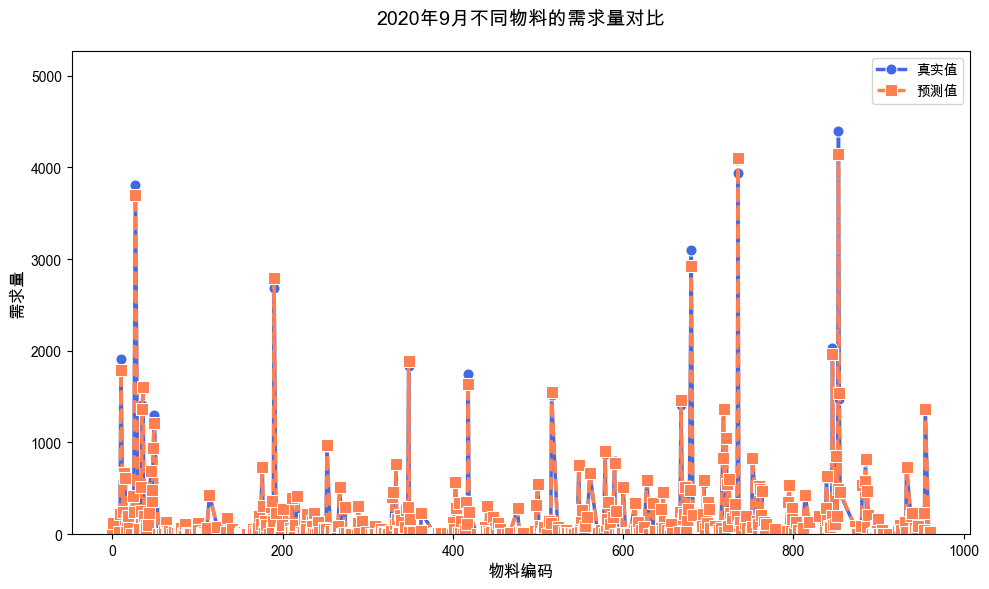

In [102]:
df_test_lgb_9 = df_predict_lgb[df_test['年月'] == '2020-09']
plt.figure(figsize=(10, 6))

# 绘制折线图（带标记点）
lineplot = sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='需求量',
    marker='o',
    markersize=8,
    linewidth=2.5,
    color='royalblue',
    label='真实值'
)
sns.lineplot(
    data=df_test_lgb_9,
    x='工厂编码_物料编码',
    y='预测值',
    marker='s',
    markersize=8,
    linewidth=2.5,
    color='coral',
    linestyle='--',
    label='预测值'
)

plt.title('2020年9月不同物料的需求量对比', fontsize=14, pad=20)
plt.xlabel('物料编码', fontsize=12)
plt.ylabel('需求量', fontsize=12)

# 调整Y轴范围（考虑数值差异大的情况）
plt.ylim(0, df_test_lgb_9['需求量'].max() * 1.2)

# 显示图表
plt.tight_layout()
plt.show()